In [10]:
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import numpy as np
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from statsmodels.tools.sm_exceptions import ValueWarning, HessianInversionWarning, ConvergenceWarning
import warnings

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/macbook/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [39]:
ticker = 'SPY'

In [40]:
tickerdf = yf.Ticker(ticker)

In [41]:
tickerdf = tickerdf.history(interval= '1d', start='2003-02-19', end='2021-12-30').Close

In [42]:
movement = tickerdf.pct_change().dropna()

In [45]:
movement.head(3)

Date
2003-02-20 00:00:00-05:00   -0.009979
2003-02-21 00:00:00-05:00    0.010079
2003-02-24 00:00:00-05:00   -0.016201
Name: Close, dtype: float64

Text(0.5, 1.0, 'Date\n2003-02-19 00:00:00-05:00     58.301208\n2003-02-20 00:00:00-05:00     57.719433\n2003-02-21 00:00:00-05:00     58.301208\n2003-02-24 00:00:00-05:00     57.356689\n2003-02-25 00:00:00-05:00     57.815254\n                                ...    \n2021-12-22 00:00:00-05:00    462.337006\n2021-12-23 00:00:00-05:00    465.213715\n2021-12-27 00:00:00-05:00    471.797485\n2021-12-28 00:00:00-05:00    471.411896\n2021-12-29 00:00:00-05:00    472.014954\nName: Close, Length: 4750, dtype: float64 Price Data')

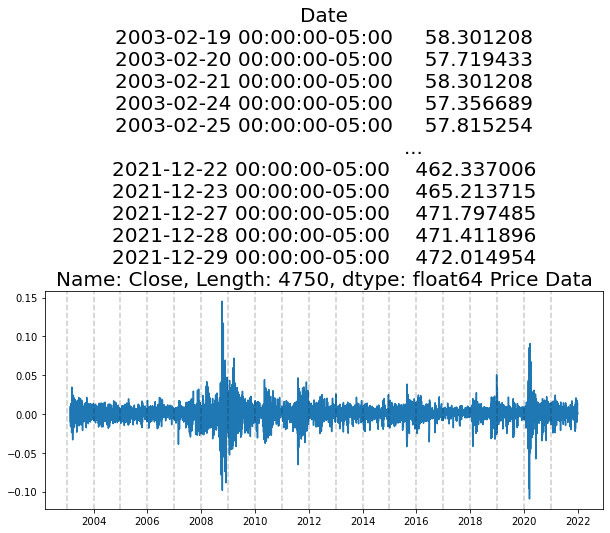

In [44]:
plt.figure(figsize=(10,4))
plt.plot(movement)
for year in range(movement.index[0].year, movement.index[-1].year+1):
    plt.axvline(datetime(year,1,1), color='k', linestyle='--', alpha=0.2)
plt.title("%s Price Data"%tickerdf, fontsize=20)

In [27]:
textdf = pd.read_csv('abcnews-date-text.csv')
textdf

,publish_date,headline_text
0,20030219,aba decides against community broadcasting lic...
1,20030219,act fire witnesses must be aware of defamation
2,20030219,a g calls for infrastructure protection summit
3,20030219,air nz staff in aust strike for pay rise
4,20030219,air nz strike to affect australian travellers
...,...,...
1244179,20211231,two aged care residents die as state records 2...
1244180,20211231,victoria records 5;919 new cases and seven deaths
1244181,20211231,wa delays adopting new close contact definition
1244182,20211231,western ringtail possums found badly dehydrate...


In [28]:
textdf.shape

(1244184, 2)

In [29]:
textdf.columns = ['date', 'headline']

In [30]:
textdf

,date,headline
0,20030219,aba decides against community broadcasting lic...
1,20030219,act fire witnesses must be aware of defamation
2,20030219,a g calls for infrastructure protection summit
3,20030219,air nz staff in aust strike for pay rise
4,20030219,air nz strike to affect australian travellers
...,...,...
1244179,20211231,two aged care residents die as state records 2...
1244180,20211231,victoria records 5;919 new cases and seven deaths
1244181,20211231,wa delays adopting new close contact definition
1244182,20211231,western ringtail possums found badly dehydrate...


In [31]:
textdf['date'] = pd.to_datetime(textdf['date'], format='%Y%m%d')

In [32]:
textdf.head(3)

,date,headline
0,2003-02-19,aba decides against community broadcasting lic...
1,2003-02-19,act fire witnesses must be aware of defamation
2,2003-02-19,a g calls for infrastructure protection summit


In [33]:
vader = SentimentIntensityAnalyzer()
f = lambda headline: vader.polarity_scores(headline)['compound']

In [34]:
textdf['compound_score'] = textdf['headline'].apply(f)

In [36]:
textdf.head(3)

,date,headline,compound_score
0,2003-02-19,aba decides against community broadcasting lic...,0.00
1,2003-02-19,act fire witnesses must be aware of defamation,-0.34
2,2003-02-19,a g calls for infrastructure protection summit,0.00


In [37]:
mean_score = textdf.groupby(['date']).mean()

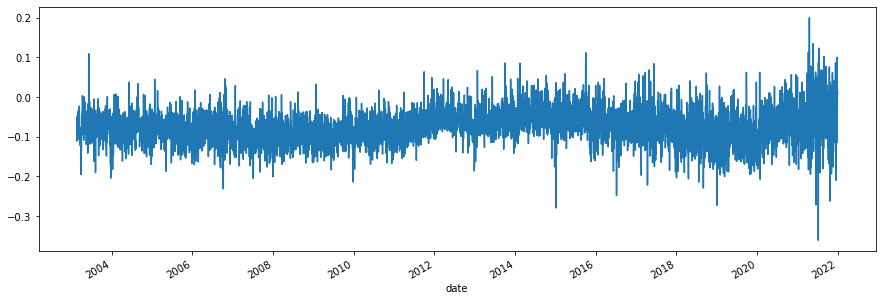

In [38]:
mean_score['compound_score'].plot(style='-', figsize=(15, 5))
plt.show()

In [ ]:
def get_buying_selling_days(mm, cc, b, s):
    
    movement = mm.pct_change()[1:]
    
    compound_score = cc
    
    def buying_condition(sub_series):
        return (sub_series > 0).all()
    
    def selling_condition(sub_series):
        return (sub_series < 0).all()
    
    buying_days = movement.rolling(b).apply(buying_condition)
    
    potential_selling_days = movement.rolling(s).apply(selling_condition)
    
    return {'buying_days': buying_days, 'potential_selling_days': potential_selling_days}